## 处理sample数据，使用tpu shapefile展示平均房价

In [ ]:
## !pip install contextily

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import datetime
import matplotlib.pyplot as plt
import contextily as cx

### 1. 读取sample数据

In [ ]:
## read the 100 lines as a demo
df_raw = pd.read_csv('sample 10000.csv', usecols= [0,2,3,5, 28,29, 31,32, 33, 34, 35 ])
df_raw['date'] = pd.to_datetime(df_raw["timestamp"], unit='s') + pd.Timedelta(days=8/24)  #pd.to_datetime()得到的是utc时间，utc+8小时=本地时间
df_raw

,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,date
0,f654d4a6-3850-4021-98df-1e4de5d5a945,22.291246,114.198296,1693528861,22.3780209,114.2580357,22.37800938,114.2580436,\N,\N,14695.6,2023-09-01 08:41:01
1,f654d4a6-3850-4021-98df-1e4de5d5a945,22.269249,114.240915,1693553045,22.3780209,114.2580357,22.37800938,114.2580436,building-garage,\N,\N,2023-09-01 15:24:05
2,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339961,114.134779,1693738855,22.36587731,114.136828,22.36585918,114.1368275,building-hospital,13322.4,\N,2023-09-03 19:00:55
3,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339928,114.134885,1693739241,22.36587731,114.136828,22.36585918,114.1368275,building-hospital,13322.4,\N,2023-09-03 19:07:21
4,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339945,114.134766,1693739590,22.36587731,114.136828,22.36585918,114.1368275,building-hospital,13322.4,\N,2023-09-03 19:13:10
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ff5caa9c-c080-4053-873c-c0075c54a400,22.321797,114.170061,1693719060,22.32172858,114.1700895,22.3217389,114.1700737,\N,\N,\N,2023-09-03 13:31:00
9996,ff5caa9c-c080-4053-873c-c0075c54a400,22.321797,114.170061,1693719073,22.32172858,114.1700895,22.3217389,114.1700737,\N,\N,\N,2023-09-03 13:31:13
9997,ff5caa9c-c080-4053-873c-c0075c54a400,22.321649,114.170101,1693719560,22.32172858,114.1700895,22.3217389,114.1700737,\N,\N,\N,2023-09-03 13:39:20
9998,ff5caa9c-c080-4053-873c-c0075c54a400,22.321649,114.170101,1693719940,22.32172858,114.1700895,22.3217389,114.1700737,\N,\N,\N,2023-09-03 13:45:40


In [ ]:
# 凌晨1：00至3：59的数据
df_raw_1_3 = df_raw[(df_raw['date'].dt.hour >= 1) & (df_raw['date'].dt.hour <= 3)]

In [ ]:
df_raw_1_3

,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,date
31,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326504,114.257659,1694111778,22.32795007,114.2589854,22.31935225,114.1753564,\N,\N,11044.66667,2023-09-08 02:36:18
32,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326499,114.257590,1694718202,22.32795007,114.2589854,22.31935225,114.1753564,\N,\N,11044.66667,2023-09-15 03:03:22
163,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441663,114.072847,1694192561,22.44166577,114.0728358,22.44159491,114.0728383,\N,12999.5,12999.5,2023-09-09 01:02:41
164,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441631,114.072864,1694194366,22.44166577,114.0728358,22.44159491,114.0728383,\N,12999.5,12999.5,2023-09-09 01:32:46
165,f6ec9f4b-8020-467c-be2c-df948aebe5dc,22.441676,114.072764,1694194953,22.44166577,114.0728358,22.44159491,114.0728383,\N,12999.5,12999.5,2023-09-09 01:42:33
...,...,...,...,...,...,...,...,...,...,...,...,...
9941,ff5caa9c-c080-4053-873c-c0075c54a400,22.321722,114.170043,1693676355,22.32172858,114.1700895,22.3217389,114.1700737,\N,\N,\N,2023-09-03 01:39:15
9942,ff5caa9c-c080-4053-873c-c0075c54a400,22.321755,114.170068,1693677488,22.32172858,114.1700895,22.3217389,114.1700737,\N,\N,\N,2023-09-03 01:58:08
9943,ff5caa9c-c080-4053-873c-c0075c54a400,22.321755,114.170068,1693678048,22.32172858,114.1700895,22.3217389,114.1700737,\N,\N,\N,2023-09-03 02:07:28
9944,ff5caa9c-c080-4053-873c-c0075c54a400,22.321755,114.170068,1693679329,22.32172858,114.1700895,22.3217389,114.1700737,\N,\N,\N,2023-09-03 02:28:49


### 2. 检查1点至3点的经纬度是否可以作为住址

In [ ]:
# 检查1点至3点的经纬度是否可以作为住址
df_raw_1_3_copy = df_raw_1_3.copy()
df_raw_1_3_copy['device_home_latitude'] = pd.to_numeric(df_raw_1_3_copy['device_home_latitude'], errors='coerce')
df_raw_1_3_copy['device_home_longitude'] = pd.to_numeric(df_raw_1_3_copy['device_home_longitude'], errors='coerce')
df_raw_1_3_copy = df_raw_1_3_copy.dropna()
df_raw_1_3_copy['device_home_latitude'].astype(float)
df_raw_1_3_copy['device_home_longitude'].astype(float)

# df_raw_1_3_copy['latitude'] = df_raw_1_3_copy['latitude'].apply(lambda x: round(x, 2))
# df_raw_1_3_copy['longitude'] = df_raw_1_3_copy['longitude'].apply(lambda x: round(x, 2))
# df_raw_1_3_copy['device_home_latitude'] = df_raw_1_3_copy['device_home_latitude'].apply(lambda x: round(x, 2))
# df_raw_1_3_copy['device_home_longitude'] = df_raw_1_3_copy['device_home_longitude'].apply(lambda x: round(x, 2))

difference_mean_latitude = (df_raw_1_3_copy['latitude'] - df_raw_1_3_copy['device_home_latitude']).mean()
difference_mean_longitude = (df_raw_1_3_copy['longitude'] - df_raw_1_3_copy['device_home_longitude']).mean()
print('difference_mean_latitude:', difference_mean_latitude, ",difference_mean_longitude:", difference_mean_longitude)

## 凌晨1点到3点的经纬度与住址经纬度差距相差很小，可以作为住址使用

difference_mean_latitude: 0.0042684387903223825 ,difference_mean_longitude: -0.0012107382258062533


### 3. 数据准备：最终数据由两部分组成，第一部分是源数据中住房价格不为空的数据，则直接使用住房经纬度和住房价格；第二部分是住房价格为空，但是1点至3点有location价格的数据，则使用1点至3点的location经纬度和价格作为其住房经纬度和价格。

In [ ]:
# 住宅价格不为空的
df_home_price_notnull = df_raw[df_raw['price_sqft_home'] != r'\N']
np.size(df_home_price_notnull['device_id'].unique())

602

In [ ]:
# 住宅价格为空，且1点-3点有所处位置价格信息的
df_predict_home_price = df_raw_1_3[(df_raw_1_3['price_sqft_home'] == r'\N') & (df_raw_1_3['price_sqft_location'] != r'\N')]
np.size(df_predict_home_price['device_id'].unique())

12

In [ ]:
np.size(df_raw['device_id'].unique())

1587

In [ ]:
df_predict_home_price

,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,date
31,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326504,114.257659,1694111778,22.32795007,114.2589854,22.31935225,114.1753564,\N,\N,11044.66667,2023-09-08 02:36:18
32,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326499,114.257590,1694718202,22.32795007,114.2589854,22.31935225,114.1753564,\N,\N,11044.66667,2023-09-15 03:03:22
1238,e60fbeb4-7e78-4985-bcc3-09ff874cb7e3,22.445384,114.035978,1694019862,\N,\N,22.44470332,114.0361581,building-apartments,\N,15023.1875,2023-09-07 01:04:22
1239,e60fbeb4-7e78-4985-bcc3-09ff874cb7e3,22.445352,114.035938,1694019911,\N,\N,22.44470332,114.0361581,building-apartments,\N,15023.1875,2023-09-07 01:05:11
1633,d2951d2e-6097-4d24-968d-cd1ea6b05a7f,22.351694,114.110107,1693766264,22.35161872,114.1101184,22.3516273,114.1101326,building-warehouse,\N,15074.8,2023-09-04 02:37:44
1634,d2951d2e-6097-4d24-968d-cd1ea6b05a7f,22.351692,114.110061,1693767992,22.35161872,114.1101184,22.3516273,114.1101326,building-warehouse,\N,15074.8,2023-09-04 03:06:32
1635,d2951d2e-6097-4d24-968d-cd1ea6b05a7f,22.351768,114.110002,1693768754,22.35161872,114.1101184,22.3516273,114.1101326,building-warehouse,\N,15074.8,2023-09-04 03:19:14
1636,d2951d2e-6097-4d24-968d-cd1ea6b05a7f,22.351757,114.110066,1693769483,22.35161872,114.1101184,22.3516273,114.1101326,building-warehouse,\N,15074.8,2023-09-04 03:31:23
1637,d2951d2e-6097-4d24-968d-cd1ea6b05a7f,22.351762,114.110019,1693769866,22.35161872,114.1101184,22.3516273,114.1101326,building-warehouse,\N,15074.8,2023-09-04 03:37:46
1671,d52a2572-a1b2-4022-8739-8d2ed7759a3e,22.450787,114.159097,1693936738,22.45064623,114.1589097,22.35826796,114.1065807,\N,\N,11286,2023-09-06 01:58:58


In [ ]:
## 将住址经纬度设置为当时位置经纬度，住房价格设置为当时位置价格

df_predict_home_price['device_home_latitude'] = df_predict_home_price['latitude']
df_predict_home_price['device_home_longitude'] = df_predict_home_price['longitude']
df_predict_home_price['price_sqft_home'] = df_predict_home_price['price_sqft_location']

df_predict_home_price

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4640\2418392827.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict_home_price['device_home_latitude'] = df_predict_home_price['latitude']
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4640\2418392827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict_home_price['device_home_longitude'] = df_predict_home_price['longitude']
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4640\2418392827.py:5: SettingWithCopyWarning: 
A value is trying to be set 

,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,date
31,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326504,114.257659,1694111778,22.326504,114.257659,22.31935225,114.1753564,\N,11044.66667,11044.66667,2023-09-08 02:36:18
32,f46a65f1-db93-477b-a2e6-798f09b778a3,22.326499,114.257590,1694718202,22.326499,114.257590,22.31935225,114.1753564,\N,11044.66667,11044.66667,2023-09-15 03:03:22
1238,e60fbeb4-7e78-4985-bcc3-09ff874cb7e3,22.445384,114.035978,1694019862,22.445384,114.035978,22.44470332,114.0361581,building-apartments,15023.1875,15023.1875,2023-09-07 01:04:22
1239,e60fbeb4-7e78-4985-bcc3-09ff874cb7e3,22.445352,114.035938,1694019911,22.445352,114.035938,22.44470332,114.0361581,building-apartments,15023.1875,15023.1875,2023-09-07 01:05:11
1633,d2951d2e-6097-4d24-968d-cd1ea6b05a7f,22.351694,114.110107,1693766264,22.351694,114.110107,22.3516273,114.1101326,building-warehouse,15074.8,15074.8,2023-09-04 02:37:44
1634,d2951d2e-6097-4d24-968d-cd1ea6b05a7f,22.351692,114.110061,1693767992,22.351692,114.110061,22.3516273,114.1101326,building-warehouse,15074.8,15074.8,2023-09-04 03:06:32
1635,d2951d2e-6097-4d24-968d-cd1ea6b05a7f,22.351768,114.110002,1693768754,22.351768,114.110002,22.3516273,114.1101326,building-warehouse,15074.8,15074.8,2023-09-04 03:19:14
1636,d2951d2e-6097-4d24-968d-cd1ea6b05a7f,22.351757,114.110066,1693769483,22.351757,114.110066,22.3516273,114.1101326,building-warehouse,15074.8,15074.8,2023-09-04 03:31:23
1637,d2951d2e-6097-4d24-968d-cd1ea6b05a7f,22.351762,114.110019,1693769866,22.351762,114.110019,22.3516273,114.1101326,building-warehouse,15074.8,15074.8,2023-09-04 03:37:46
1671,d52a2572-a1b2-4022-8739-8d2ed7759a3e,22.450787,114.159097,1693936738,22.450787,114.159097,22.35826796,114.1065807,\N,11286,11286,2023-09-06 01:58:58


In [ ]:
## 合并df_home_price_notnull和df_predict_home_price

In [ ]:
df_home_price_notnull.columns

Index(['device_id', 'latitude', 'longitude', 'timestamp',
       'device_home_latitude', 'device_home_longitude', 'device_work_latitude',
       'device_work_longitude', 'location_type', 'price_sqft_home',
       'price_sqft_location', 'date'],
      dtype='object')

In [ ]:
df_predict_home_price.columns

Index(['device_id', 'latitude', 'longitude', 'timestamp',
       'device_home_latitude', 'device_home_longitude', 'device_work_latitude',
       'device_work_longitude', 'location_type', 'price_sqft_home',
       'price_sqft_location', 'date'],
      dtype='object')

In [ ]:
set(df_predict_home_price.columns) - set(df_home_price_notnull.columns)

set()

In [ ]:
df_home_price_notnull.shape

(4089, 12)

In [ ]:
df_predict_home_price.shape

(40, 12)

In [ ]:
df_cleaned = pd.concat([df_home_price_notnull, df_predict_home_price], ignore_index=True)

In [ ]:
df_cleaned.shape

(4129, 12)

In [ ]:
df_cleaned.head()

,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,date
0,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339961,114.134779,1693738855,22.36587731,114.136828,22.36585918,114.1368275,building-hospital,13322.4,\N,2023-09-03 19:00:55
1,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339928,114.134885,1693739241,22.36587731,114.136828,22.36585918,114.1368275,building-hospital,13322.4,\N,2023-09-03 19:07:21
2,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339945,114.134766,1693739590,22.36587731,114.136828,22.36585918,114.1368275,building-hospital,13322.4,\N,2023-09-03 19:13:10
3,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339966,114.134692,1693739974,22.36587731,114.136828,22.36585918,114.1368275,building-hospital,13322.4,\N,2023-09-03 19:19:34
4,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339965,114.134650,1693740354,22.36587731,114.136828,22.36585918,114.1368275,building-hospital,13322.4,\N,2023-09-03 19:25:54


In [ ]:
df_cleaned['device_home_latitude'] = pd.to_numeric(df_cleaned['device_home_latitude'], errors='coerce')
df_cleaned['device_home_longitude'] = pd.to_numeric(df_cleaned['device_home_longitude'], errors='coerce')
df_cleaned['price_sqft_home'] = pd.to_numeric(df_cleaned['price_sqft_home'], errors='coerce')
df_cleaned['device_home_latitude'].astype(float)
df_cleaned['device_home_longitude'].astype(float)
df_cleaned['price_sqft_home'].astype(float)
df_cleaned.dtypes

device_id                        object
latitude                        float64
longitude                       float64
timestamp                         int64
device_home_latitude            float64
device_home_longitude           float64
device_work_latitude             object
device_work_longitude            object
location_type                    object
price_sqft_home                 float64
price_sqft_location              object
date                     datetime64[ns]
dtype: object

### 4. 读取tpu shapefile

In [ ]:
gfs = []
for f in os.listdir('tpu_data_geo/'):
    if 'shp' not in f:
        continue
    if '._' in f:
        continue
    ## GBK for encode Chinese
    shapefile = gpd.read_file('tpu_data_geo/%s' % f, encoding="GBK")
    tupid = f.split('_')[1].split('.')[0]
    shapefile['tpuid'] = tupid
    ## set crs
    shapefile.crs = 'EPSG:4326'
    gfs.append(shapefile)
gfs = gpd.GeoDataFrame(pd.concat(gfs))
## select two columns only
sel_cols = ['tpuid', 'geometry']
gfs_sel = gfs[sel_cols]

In [ ]:
shapefile

,OBJECTID,PPU,SPU,TPU,SB_VC,TYPE_Eng,TYPE_TC,TYPE_SC,Shape_Leng,Shape_Area,geometry,tpuid
0,985,9,97,976,8,Village Clusters,村落統計區,村落统计区,2188.0186,106635.718451,"MULTIPOLYGON (((114.04660 22.28246, 114.04659 ...",976


In [ ]:
gfs_sel

,tpuid,geometry
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ..."
0,112,"POLYGON ((114.13725 22.28459, 114.13723 22.284..."
0,113,"POLYGON ((114.14963 22.28368, 114.14940 22.283..."
0,114,"POLYGON ((114.15307 22.28257, 114.15274 22.282..."
0,115,"POLYGON ((114.14818 22.28841, 114.14801 22.288..."
...,...,...
0,950S,"MULTIPOLYGON (((113.97876 22.32745, 113.97876 ..."
0,961S,"MULTIPOLYGON (((114.00320 22.26172, 114.00317 ..."
0,971S,"MULTIPOLYGON (((114.07899 22.28688, 114.07901 ..."
0,975,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ..."


<Axes: >

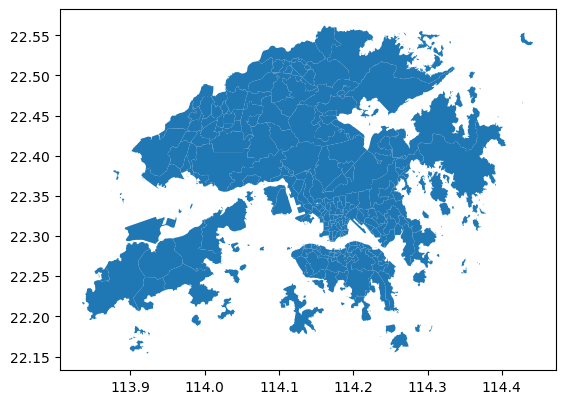

In [ ]:
## the filed geometry is used when do plotting
gfs_sel.plot()

### 5. 计算每个tpu的平均房价，在tpu地图中展示

In [ ]:
## 将价格数据转换为GeoDataFrame
geometry = gpd.points_from_xy(df_cleaned['device_home_longitude'], df_cleaned['device_home_latitude'])
price_gdf = gpd.GeoDataFrame(df_cleaned, geometry=geometry)
price_gdf

,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,date,geometry
0,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339961,114.134779,1693738855,22.365877,114.136828,22.36585918,114.1368275,building-hospital,13322.40000,\N,2023-09-03 19:00:55,POINT (114.13683 22.36588)
1,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339928,114.134885,1693739241,22.365877,114.136828,22.36585918,114.1368275,building-hospital,13322.40000,\N,2023-09-03 19:07:21,POINT (114.13683 22.36588)
2,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339945,114.134766,1693739590,22.365877,114.136828,22.36585918,114.1368275,building-hospital,13322.40000,\N,2023-09-03 19:13:10,POINT (114.13683 22.36588)
3,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339966,114.134692,1693739974,22.365877,114.136828,22.36585918,114.1368275,building-hospital,13322.40000,\N,2023-09-03 19:19:34,POINT (114.13683 22.36588)
4,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339965,114.134650,1693740354,22.365877,114.136828,22.36585918,114.1368275,building-hospital,13322.40000,\N,2023-09-03 19:25:54,POINT (114.13683 22.36588)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4124,da8f3a19-10fd-4960-abfb-631130e35286,22.303065,114.258608,1694196933,22.303065,114.258608,22.30304116,114.2593449,building-residential,21079.76923,21079.76923,2023-09-09 02:15:33,POINT (114.25861 22.30306)
4125,da8f3a19-10fd-4960-abfb-631130e35286,22.303065,114.258608,1694200683,22.303065,114.258608,22.30304116,114.2593449,building-residential,21079.76923,21079.76923,2023-09-09 03:18:03,POINT (114.25861 22.30306)
4126,fd70a5a7-1dd9-4a0e-96d8-1b10cf4b7c50,22.291076,114.203297,1694374181,22.291076,114.203297,22.29104309,114.2032035,building-apartments,19539.83333,19539.83333,2023-09-11 03:29:41,POINT (114.20330 22.29108)
4127,fe9638e4-ae07-639d-a71c-ab0b87f8b07a,22.424114,114.238526,1693766653,22.424114,114.238526,22.51497733,114.0654478,\N,9857.50000,9857.5,2023-09-04 02:44:13,POINT (114.23853 22.42411)


In [ ]:
merged = gpd.sjoin(gfs_sel, price_gdf, how='left', op='intersects')
merged

D:\code\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4640\3048035934.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  merged = gpd.sjoin(gfs_sel, price_gdf, how='left', op='intersects')


,tpuid,geometry,index_right,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,date
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2581.0,d3c8004a-a305-4536-938c-be8ab8ffb646,22.280667,114.129750,1.694237e+09,22.280915,114.129358,22.28092205,114.1293497,building-residential,20338.80000,20338.8,2023-09-09 13:15:57
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2582.0,d3c8004a-a305-4536-938c-be8ab8ffb646,22.280741,114.129666,1.694237e+09,22.280915,114.129358,22.28092205,114.1293497,building-residential,20338.80000,20338.8,2023-09-09 13:16:57
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2584.0,d3c8004a-a305-4536-938c-be8ab8ffb646,22.280762,114.129587,1.694265e+09,22.280915,114.129358,22.28092205,114.1293497,building-residential,20338.80000,20338.8,2023-09-09 21:15:40
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2583.0,d3c8004a-a305-4536-938c-be8ab8ffb646,22.280704,114.129590,1.694237e+09,22.280915,114.129358,22.28092205,114.1293497,building-residential,20338.80000,20338.8,2023-09-09 13:19:07
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2580.0,d3c8004a-a305-4536-938c-be8ab8ffb646,22.280719,114.129488,1.693629e+09,22.280915,114.129358,22.28092205,114.1293497,building-residential,20338.80000,20338.8,2023-09-02 12:33:53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,975,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",2457.0,8fe00130-2426-67f4-a8a1-40eed19176ca,22.276657,114.173786,1.693996e+09,22.352965,114.060135,22.35296469,114.0601384,\N,11166.80000,14345,2023-09-06 18:27:30
0,975,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",2456.0,8fe00130-2426-67f4-a8a1-40eed19176ca,22.278649,114.176676,1.693995e+09,22.352965,114.060135,22.35296469,114.0601384,\N,11166.80000,16585.33333,2023-09-06 18:15:28
0,975,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",3786.0,ba6efc6e-4848-429b-a9cc-4bd65a8aca91,22.281545,114.156776,1.694061e+09,22.354152,114.060463,22.3541507,114.0604655,building-commercial,11931.34783,\N,2023-09-07 12:26:01
0,975,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",3787.0,ba6efc6e-4848-429b-a9cc-4bd65a8aca91,22.360310,114.090950,1.694653e+09,22.354152,114.060463,22.3541507,114.0604655,\N,11931.34783,\N,2023-09-14 08:51:56


In [ ]:
merged.dtypes

tpuid                            object
geometry                       geometry
index_right                     float64
device_id                        object
latitude                        float64
longitude                       float64
timestamp                       float64
device_home_latitude            float64
device_home_longitude           float64
device_work_latitude             object
device_work_longitude            object
location_type                    object
price_sqft_home                 float64
price_sqft_location              object
date                     datetime64[ns]
dtype: object

#### 计算平均房价方法1：groupby()

In [ ]:
## 使用聚合函数求平均房价
merged['price_mean'] = merged.groupby('tpuid')['price_sqft_home'].transform('mean')
merged

,tpuid,geometry,index_right,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,date,price_mean
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2581.0,d3c8004a-a305-4536-938c-be8ab8ffb646,22.280667,114.129750,1.694237e+09,22.280915,114.129358,22.28092205,114.1293497,building-residential,20338.80000,20338.8,2023-09-09 13:15:57,20237.638993
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2582.0,d3c8004a-a305-4536-938c-be8ab8ffb646,22.280741,114.129666,1.694237e+09,22.280915,114.129358,22.28092205,114.1293497,building-residential,20338.80000,20338.8,2023-09-09 13:16:57,20237.638993
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2584.0,d3c8004a-a305-4536-938c-be8ab8ffb646,22.280762,114.129587,1.694265e+09,22.280915,114.129358,22.28092205,114.1293497,building-residential,20338.80000,20338.8,2023-09-09 21:15:40,20237.638993
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2583.0,d3c8004a-a305-4536-938c-be8ab8ffb646,22.280704,114.129590,1.694237e+09,22.280915,114.129358,22.28092205,114.1293497,building-residential,20338.80000,20338.8,2023-09-09 13:19:07,20237.638993
0,111,"MULTIPOLYGON (((114.12294 22.27288, 114.12285 ...",2580.0,d3c8004a-a305-4536-938c-be8ab8ffb646,22.280719,114.129488,1.693629e+09,22.280915,114.129358,22.28092205,114.1293497,building-residential,20338.80000,20338.8,2023-09-02 12:33:53,20237.638993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,975,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",2457.0,8fe00130-2426-67f4-a8a1-40eed19176ca,22.276657,114.173786,1.693996e+09,22.352965,114.060135,22.35296469,114.0601384,\N,11166.80000,14345,2023-09-06 18:27:30,11421.649277
0,975,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",2456.0,8fe00130-2426-67f4-a8a1-40eed19176ca,22.278649,114.176676,1.693995e+09,22.352965,114.060135,22.35296469,114.0601384,\N,11166.80000,16585.33333,2023-09-06 18:15:28,11421.649277
0,975,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",3786.0,ba6efc6e-4848-429b-a9cc-4bd65a8aca91,22.281545,114.156776,1.694061e+09,22.354152,114.060463,22.3541507,114.0604655,building-commercial,11931.34783,\N,2023-09-07 12:26:01,11421.649277
0,975,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",3787.0,ba6efc6e-4848-429b-a9cc-4bd65a8aca91,22.360310,114.090950,1.694653e+09,22.354152,114.060463,22.3541507,114.0604655,\N,11931.34783,\N,2023-09-14 08:51:56,11421.649277


<Axes: >

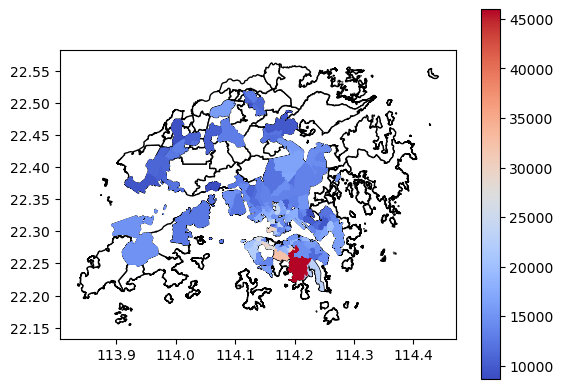

In [ ]:
## 绘制地图
ax = gfs_sel.plot(color="white", edgecolor="black")
merged.plot(column='price_mean', cmap='coolwarm', legend=True, ax=ax)

#### 计算平均房价方法2：dissolve()

In [ ]:
## 求每个tpu的平均房价
dissolve_data = merged.dissolve(by='tpuid', aggfunc='mean', as_index=False)
dissolve_data

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4640\3774087175.py:2: FutureWarning: The default value of numeric_only in aggfunc='mean' within pandas.DataFrameGroupBy.agg used in dissolve is deprecated. In pandas 2.0, numeric_only will default to False. Either specify numeric_only as additional argument in dissolve() or select only columns which should be valid for the function.
  dissolve_data = merged.dissolve(by='tpuid', aggfunc='mean', as_index=False)


,tpuid,geometry,index_right,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,price_sqft_home,price_mean
0,111,"MULTIPOLYGON (((114.11271 22.28619, 114.11272 ...",1845.166667,22.287925,114.169254,1.694068e+09,22.282749,114.130070,20237.638993,20237.638993
1,112,"POLYGON ((114.13705 22.28432, 114.13688 22.284...",1839.437500,22.293732,114.171034,1.694167e+09,22.285863,114.139289,26037.988124,26037.988124
2,113,"POLYGON ((114.14918 22.28319, 114.14909 22.283...",3293.274510,22.289340,114.152341,1.694101e+09,22.284648,114.148220,14522.820915,14522.820915
3,114,"POLYGON ((114.15307 22.28257, 114.15274 22.282...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,115,"POLYGON ((114.14818 22.28841, 114.14801 22.288...",3920.000000,22.326470,114.023176,1.694426e+09,22.287918,114.145094,24646.500000,24646.500000
...,...,...,...,...,...,...,...,...,...,...
209,950S,"MULTIPOLYGON (((113.91297 22.29533, 113.91295 ...",1425.625000,22.292111,113.945687,1.694095e+09,22.293468,113.947147,14809.110570,14809.110570
210,961S,"MULTIPOLYGON (((114.03311 22.25878, 114.03313 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,971S,"MULTIPOLYGON (((114.02163 22.28081, 114.02162 ...",2177.600000,22.296890,114.055511,1.693816e+09,22.307690,114.013143,12516.577778,12516.577778
212,975,"MULTIPOLYGON (((114.06246 22.34125, 114.06249 ...",2900.500000,22.292597,114.158157,1.694315e+09,22.353361,114.060244,11421.649277,11421.649277


<Axes: >

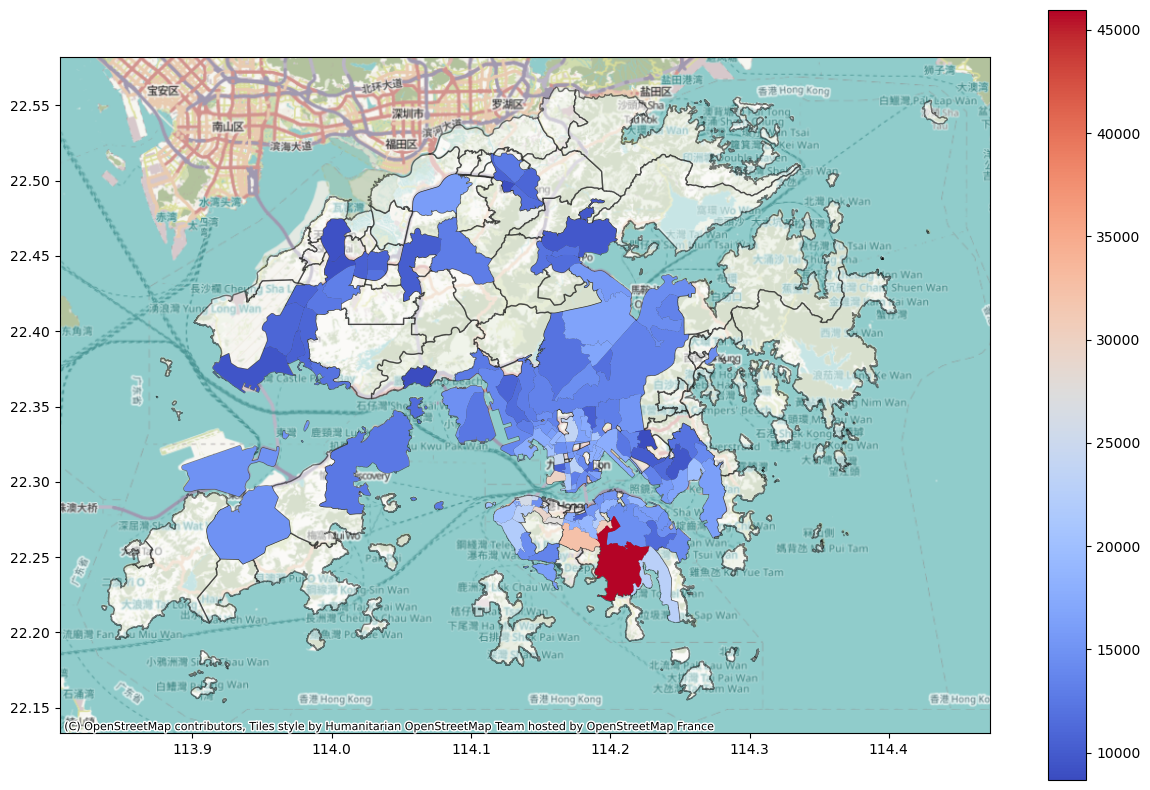

In [ ]:
# 绘制地图
fig, ax = plt.subplots(figsize=(15, 10))
ax = gfs_sel.plot(ax=ax, alpha=0.5, color="white", edgecolor="black")
cx.add_basemap(ax, crs=gfs_sel.crs)  ## 添加瓦片地图
dissolve_data.plot(ax=ax, column='price_sqft_home', cmap='coolwarm', legend=True)

## 读取全部数据集

In [ ]:
df_t = pd.read_csv('sample 10000.csv', usecols= [0,2,3,5, 28,29, 31,32, 33, 34, 35 ])
name_list = df_t.columns.tolist()

In [ ]:
r = pd.read_csv('000000_0_fb744a52-2d44-4e8d-8ff1-85aeda22a123_20231207_153237_00071_9h6es',
                usecols= [0,2,3,5, 28,29, 31,32, 33, 34, 35 ],
                on_bad_lines='warn',header=None, names=name_list, iterator=True)

In [ ]:
## expected 37 fields, saw 38    是否需要设置分隔符？

In [ ]:
df_test = pd.read_csv('000000_0_fb744a52-2d44-4e8d-8ff1-85aeda22a123_20231207_153237_00071_9h6es', on_bad_lines='warn', nrows=200000)

Skipping line 166437: expected 37 fields, saw 38

Skipping line 181055: expected 37 fields, saw 38



In [ ]:
loop = True
chunkSize = 100000
chunks = []
while loop:
    try:
        chunk = r.get_chunk(chunkSize)
        chunks.append(chunk)
     #停止迭代，数据读到尾部，结束循环。
    except StopIteration:
        loop = False
        print("文件读取完毕.")
df = pd.concat(chunks, ignore_index=True)

文件读取完毕.


In [ ]:
df['date'] = pd.to_datetime(df["timestamp"], unit='s') + pd.Timedelta(days=8/24)  #pd.to_datetime()得到的是utc时间，utc+8小时=本地时间

In [ ]:
df[df['price_sqft_home']=='commercia']

,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,date
166436,f34b8f61-40b0-4a1f-853a-ebb71566a6eb,22.336737,114.149350,1694344031,22.336130172093025,114.1494757023256,22.3356154090164,114.14922370245901,building-industrial,commercia,18568.0,2023-09-10 19:07:11
181054,f34b8f61-40b0-4a1f-853a-ebb71566a6eb,22.336704,114.149374,1694310338,22.336130172093025,114.1494757023256,22.3356154090164,114.14922370245901,building-industrial,commercia,18568.0,2023-09-10 09:45:38
241981,304d8a3a-8029-44cd-8b7d-4dc6e9e42637,22.336991,114.149661,1694050124,22.433829526315794,113.99132073684211,22.33686125,114.14962560714285,building-industrial,commercia,\N,2023-09-07 09:28:44
241982,304d8a3a-8029-44cd-8b7d-4dc6e9e42637,22.337086,114.149612,1694053673,22.433829526315794,113.99132073684211,22.33686125,114.14962560714285,building-industrial,commercia,\N,2023-09-07 10:27:53
241983,304d8a3a-8029-44cd-8b7d-4dc6e9e42637,22.336941,114.149661,1694076239,22.433829526315794,113.99132073684211,22.33686125,114.14962560714285,building-industrial,commercia,\N,2023-09-07 16:43:59
...,...,...,...,...,...,...,...,...,...,...,...,...
61401068,67dc5b08-f3a4-4196-9b27-67157adc2c65,22.336720,114.149376,1694308044,22.34194308241758,114.15555776520146,22.243349858974366,114.1489385410256,building-industrial,commercia,\N,2023-09-10 09:07:24
61401805,5877dc00-fd25-4f22-bb5c-f70d13b8fbd6,22.336600,114.149642,1693893175,22.36375270786517,114.12952645056181,22.36364442556391,114.12954632706767,building-industrial,commercia,\N,2023-09-05 13:52:55
61558557,c1d32bd2-8e76-4cad-a301-73ef8e3544b9,22.336720,114.149376,1694603008,22.462906899999997,114.18987569999993,22.457788199999996,114.17191110000002,building-industrial,commercia,\N,2023-09-13 19:03:28
61699636,fb2e6651-7aa2-4bb1-8f89-be8aaa99a61a,22.336720,114.149376,1694243791,22.371861462068964,114.11984651149426,22.365761935294117,114.12035921764706,building-industrial,commercia,14613.42857142857,2023-09-09 15:16:31


In [ ]:
df

,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,date
0,f654d4a6-3850-4021-98df-1e4de5d5a945,22.291246,114.198296,1693528861,22.37802089590164,114.2580357467213,22.378009384552843,114.25804358699189,\N,\N,14695.6,2023-09-01 08:41:01
1,f654d4a6-3850-4021-98df-1e4de5d5a945,22.269249,114.240915,1693553045,22.37802089590164,114.2580357467213,22.378009384552843,114.25804358699189,building-garage,\N,\N,2023-09-01 15:24:05
2,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339961,114.134779,1693738855,22.36587730666667,114.13682803666667,22.365859175409835,114.13682745573773,building-hospital,13322.4,\N,2023-09-03 19:00:55
3,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339928,114.134885,1693739241,22.36587730666667,114.13682803666667,22.365859175409835,114.13682745573773,building-hospital,13322.4,\N,2023-09-03 19:07:21
4,f6580b80-1451-48b9-b99f-685c17a54fc8,22.339945,114.134766,1693739590,22.36587730666667,114.13682803666667,22.365859175409835,114.13682745573773,building-hospital,13322.4,\N,2023-09-03 19:13:10
...,...,...,...,...,...,...,...,...,...,...,...,...
62969747,b459657d-9ab1-4f73-9154-28f6044e2df7,22.321577,114.260256,1694439893,22.321534486486485,114.2602551189189,22.321736599999994,114.26014184444443,\N,13971.285714285714,13971.285714285714,2023-09-11 21:44:53
62969748,b460a842-0630-4ebf-963b-6285b81f5574,22.310000,114.230000,1694668126,\N,\N,\N,\N,\N,\N,\N,2023-09-14 13:08:46
62969749,b4797889-7ba8-6302-2099-7fd7d0cf6e40,22.281597,114.159020,1693716923,22.266985415669517,114.23429762393165,22.267076286445782,114.23430978042168,building-commercial,\N,\N,2023-09-03 12:55:23
62969750,b4797889-7ba8-6302-2099-7fd7d0cf6e40,22.284408,114.143100,1694339102,22.266985415669517,114.23429762393165,22.267076286445782,114.23430978042168,\N,\N,24369.0,2023-09-10 17:45:02


## 建筑shape file

In [ ]:
for f in os.listdir('Building_SHP/'):
    if 'shp' not in f:
        continue
    if '._' in f:
        continue
    print(f)


BUILDING_INFO.shp
BUILDING_LOT_NO_INFO.shp
BUILDING_NAME.shp
BUILDING_STRUCTURE.shp
BUILDING_WORKS_HISTORY.shp
CT_BUILDING_CATEGORY.shp
CT_BUILDING_INFO_TYPE.shp
CT_BUILDING_STATUS.shp
CT_BUILDING_STRUCTURE_TYPE.shp
CT_BUILDING_WORKS_TYPE.shp
CT_NAME_INFO_SOURCE.shp
CT_NAME_STATUS.shp
OCCUPATION_PERMIT.shp
OP_BUILDING_STRUCTURE.shp


In [ ]:
# bd_gfs = []
bd_dic = {}
for f in os.listdir('Building_SHP/'):
    if 'shp' not in f:
        continue
    if '._' in f:
        continue
    ## GBK for encode Chinese
    shapefile = gpd.read_file('Building_SHP/%s' % f, encoding="GBK")
    name = f.split('.')[0]
    shapefile['content'] = name
    ## set crs
    shapefile.crs = 'EPSG:4326'
    bd_dic[name] = gpd.GeoDataFrame(shapefile)

In [ ]:
bd_dic['BUILDING_INFO']

,OBJECTID,BUILDINGST,INFOTYPE,INFODESCRI,BEGIN_LIFE,END_LIFESP,geometry,content
0,1,193634,HS,Public Rental Housing,None,None,None,BUILDING_INFO
1,2,193648,HS,Public Rental Housing,None,None,None,BUILDING_INFO
2,3,193656,HS,Public Rental Housing,None,None,None,BUILDING_INFO
3,4,193687,HS,Public Rental Housing,None,None,None,BUILDING_INFO
4,5,193632,HS,Public Rental Housing,None,None,None,BUILDING_INFO
...,...,...,...,...,...,...,...,...
11830,11831,384896,IU,Residence (with residents' recreational facili...,None,None,None,BUILDING_INFO
11831,11832,265845,IU,Dormitory & detoxification block Activity bloc...,None,None,None,BUILDING_INFO
11832,11833,265852,IU,Dormitory & detoxification block Activity bloc...,None,None,None,BUILDING_INFO
11833,11834,265853,IU,Dormitory & detoxification block Activity bloc...,None,None,None,BUILDING_INFO


In [ ]:
bd_dic['BUILDING_LOT_NO_INFO']

,OBJECTID,BUILDINGST,DD_SD_TYPE,DD_SD_NO,LOTTYPE,LOTNO,SECTION1,SUBSECTION,SECTION2,SUBSECTI00,SECTION3,SUBSECTI01,SECTION4,EXTPORTION,MISCNO,geometry,content
0,1,350798,-11,-11,GLA,IS534,None,None,None,None,None,None,None,-11,-11,None,BUILDING_LOT_NO_INFO
1,2,197825,DD,309,LOT,45,None,None,None,None,None,None,None,-11,-11,None,BUILDING_LOT_NO_INFO
2,3,196100,DD,302,LOT,369,None,None,None,None,None,None,None,-11,-11,None,BUILDING_LOT_NO_INFO
3,4,186341,DD,302,LOT,166,RP,None,None,None,None,None,None,-11,-11,None,BUILDING_LOT_NO_INFO
4,5,174404,DD,311,LOT,760,None,None,None,None,None,None,None,-11,-11,None,BUILDING_LOT_NO_INFO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25348,25349,36214,DD,296,LOT,786,None,None,None,None,None,None,None,-11,-11,None,BUILDING_LOT_NO_INFO
25349,25350,384285,-11,-11,STT,SX3060,None,None,None,None,None,None,None,-11,-11,None,BUILDING_LOT_NO_INFO
25350,25351,410716,-11,-11,KIL,2753,(RP),None,None,None,None,None,None,-11,-11,None,BUILDING_LOT_NO_INFO
25351,25352,384283,-11,-11,ML,117,A,None,(RP),None,None,None,None,-11,-11,None,BUILDING_LOT_NO_INFO


In [ ]:
bd_dic['BUILDING_NAME']

,OBJECTID,BUILDINGST,INFOSOURCE,BUILDINGNA,BUILDING00,NAMESTATUS,geometry,content
0,1,38,S,None,瀵岃嚚闁,E,None,BUILDING_NAME
1,2,189,R,HONG KONG OUTWARD BOUND SCHOOL,棣欐腐澶栧睍瑷撶反瀛告牎,E,None,BUILDING_NAME
2,3,211,S,Kwu Tung (Tung Fong) Public Toilet,鍙ゆ礊锛堟澅鏂癸級鍏寤,E,None,BUILDING_NAME
3,4,212,S,None,杌嶅湴鏉戝叕鎵,E,None,BUILDING_NAME
4,5,226,S,PCCW Lai Chi Wo Telephone Exchange,鑽旀灊绐╂熸〒,E,None,BUILDING_NAME
...,...,...,...,...,...,...,...,...
93048,93049,429767,S,Greenwood Tower 5,缈犳櫙闁ｇ锛曞骇,E,None,BUILDING_NAME
93049,93050,429858,S,iCity,None,E,None,BUILDING_NAME
93050,93051,429921,S,Royal Harmony,鍏鐓岃嚭,E,None,BUILDING_NAME
93051,93052,430031,S,InterContinental Grand Stanford Hong Kong,娴锋櫙鍢夌忛厭搴,E,None,BUILDING_NAME


In [ ]:
bd_dic['BUILDING_STRUCTURE']

,OBJECTID,BUILDINGST,BUILDINGCS,BUILDING00,CATEGORY,STATUS,STATUSDATE,OFFICIALBU,OFFICIAL00,NUMABOVEGR,NUMBASEMEN,TOPHEIGHT,BASEHEIGHT,GROSSFLOOR,RECORDCREA,RECORDUPDA,SHAPE_Leng,SHAPE_Area,geometry,content
0,1,243561,0162608928T20071224,T,5,A,None,None,None,NaN,NaN,NaN,None,NaN,20071224,20080116,17.431311,14.453672,"POLYGON ((801628.52080 808931.58950, 801628.19...",BUILDING_STRUCTURE
1,2,243562,0163008922T20071224,T,5,A,None,None,None,NaN,NaN,NaN,None,NaN,20071224,20080116,12.960214,9.240269,"POLYGON ((801632.33030 808924.20390, 801632.64...",BUILDING_STRUCTURE
2,3,243563,0163108931T20071224,T,5,A,None,None,None,NaN,NaN,NaN,None,NaN,20071224,20080116,22.352643,31.015898,"POLYGON ((801628.19410 808928.17520, 801628.52...",BUILDING_STRUCTURE
3,4,243564,0163608930T20071224,T,5,A,None,None,None,NaN,NaN,NaN,None,NaN,20071224,20080116,18.595424,21.319706,"POLYGON ((801634.82760 808932.88050, 801638.87...",BUILDING_STRUCTURE
4,5,243565,0163808933T20071224,T,5,A,None,None,None,NaN,NaN,NaN,None,NaN,20071224,20080116,19.609693,20.145564,"POLYGON ((801639.98590 808931.90240, 801638.87...",BUILDING_STRUCTURE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340747,340748,403798,6296144493T20190806,T,5,A,None,None,None,NaN,NaN,NaN,None,NaN,20190806,20190829,25.017263,39.012734,"POLYGON ((862965.13280 844495.00990, 862962.31...",BUILDING_STRUCTURE
340748,340749,4963,6296144621T20050430,T,9,A,None,None,None,NaN,NaN,10.1,None,NaN,20050430,20050725,34.926430,66.714851,"POLYGON ((862964.53450 844624.03560, 862964.23...",BUILDING_STRUCTURE
340749,340750,4952,6299144635T20050430,T,9,A,None,None,澶╁悗瀹,NaN,NaN,9.7,None,NaN,20050430,20050725,43.341399,117.309442,"POLYGON ((862993.23800 844627.56190, 862983.86...",BUILDING_STRUCTURE
340750,340751,5040,6299744554T20050430,T,9,A,None,None,None,NaN,NaN,17.5,None,NaN,20050430,20050725,22.022560,29.099489,"POLYGON ((863000.00000 844551.51600, 862995.03...",BUILDING_STRUCTURE


In [ ]:
bd_dic['BUILDING_WORKS_HISTORY']

,OBJECTID,BUILDINGST,WORKSTYPE,WORKSDATE,geometry,content
0,1,193634,CD,19990201,None,BUILDING_WORKS_HISTORY
1,2,193648,CD,19990901,None,BUILDING_WORKS_HISTORY
2,3,193656,CD,19990201,None,BUILDING_WORKS_HISTORY
3,4,193687,CD,19990201,None,BUILDING_WORKS_HISTORY
4,5,193632,CD,19990901,None,BUILDING_WORKS_HISTORY
...,...,...,...,...,...,...
58813,58814,223639,BW,19980216,None,BUILDING_WORKS_HISTORY
58814,58815,118681,SFW,20020930,None,BUILDING_WORKS_HISTORY
58815,58816,118681,DW,20040429,None,BUILDING_WORKS_HISTORY
58816,58817,118681,CC,20051017,None,BUILDING_WORKS_HISTORY


In [ ]:
bd_dic['CT_BUILDING_CATEGORY']

,OBJECTID,CODE,DESCRIPTIO,NOTE,geometry,content
0,1,1,"Legal Private Buildings, and HA/HS buildings u...",These include HA's Home Ownership Scheme (HOS)...,None,CT_BUILDING_CATEGORY
1,2,2,New Territories Small Houses,A type of New Territories Exempted House (NTEH),None,CT_BUILDING_CATEGORY
2,3,3,HA Buildings (including towers and podiums),Public housing and HOS estates (but except tho...,None,CT_BUILDING_CATEGORY
3,4,4,Other Government Buildings,Including towers and podiums of government own...,None,CT_BUILDING_CATEGORY
4,5,5,Miscellaneous Structures,Including temporary and open structures,None,CT_BUILDING_CATEGORY
5,6,9,Category is not assigned,N/A,None,CT_BUILDING_CATEGORY


In [ ]:
bd_dic['CT_BUILDING_INFO_TYPE']

,OBJECTID,CODE,DESCRIPTIO,NOTE,geometry,content
0,1,HS,HA Housing Scheme,Applicable for PSPS buildings under Category 1...,None,CT_BUILDING_INFO_TYPE
1,2,IU,Intended Usage,Information to be based on BLD_TY_OP from Buil...,None,CT_BUILDING_INFO_TYPE


In [ ]:
bd_dic['CT_BUILDING_STATUS']

,OBJECTID,CODE,DESCRIPTIO,NOTE,geometry,content
0,1,A,Active,Building structure is substantially completed ...,None,CT_BUILDING_STATUS


In [ ]:
bd_dic['CT_BUILDING_STRUCTURE_TYPE']

,OBJECTID,CODE,DESCRIPTIO,NOTE,geometry,content
0,1,T,Tower,"All permanent buildings, open side structures ...",None,CT_BUILDING_STRUCTURE_TYPE
1,2,P,Podium,A containment with facilities for a designated...,None,CT_BUILDING_STRUCTURE_TYPE
2,3,U,Underground Structure,"A building structure entirely below ground, wi...",None,CT_BUILDING_STRUCTURE_TYPE


In [ ]:
bd_dic['CT_BUILDING_WORKS_TYPE']

,OBJECTID,CODE,DESCRIPTIO,NOTE,geometry,content
0,1,BW,Issue date for the Certificate of Exemption in...,Applicable for Category 2 Building Only,None,CT_BUILDING_WORKS_TYPE
1,2,SFW,Issue date for the Certificate of Exemption in...,Applicable for Category 2 Building Only,None,CT_BUILDING_WORKS_TYPE
2,3,DW,Issue date for the Certificate of Exemption in...,Applicable for Category 2 Building Only,None,CT_BUILDING_WORKS_TYPE
3,4,CC,Issue date for the Certificate of Compliance,Applicable for Category 2 Building Only,None,CT_BUILDING_WORKS_TYPE
4,5,CD,Completion Date,As recorded/reported by responsible authority,None,CT_BUILDING_WORKS_TYPE
5,6,DCD,Demolition Completion Date,As recorded/reported by responsible authority,None,CT_BUILDING_WORKS_TYPE


In [ ]:
bd_dic['CT_NAME_INFO_SOURCE']

,OBJECTID,CODE,DESCRIPTIO,geometry,content
0,1,R,Recorded name provided by RVD,None,CT_NAME_INFO_SOURCE
1,2,S,Surveyed name provided by LandsD,None,CT_NAME_INFO_SOURCE


In [ ]:
bd_dic['CT_NAME_STATUS']

,OBJECTID,CODE,DESCRIPTIO,geometry,content
0,1,E,Default,None,CT_NAME_STATUS
1,2,O,Other Name (Alias),None,CT_NAME_STATUS
2,3,P,Proposed,None,CT_NAME_STATUS
3,4,R,Renamed,None,CT_NAME_STATUS


In [ ]:
bd_dic['OCCUPATION_PERMIT']

,OBJECTID,OPNO,OPDATE,DOMESTICGF,NONDOMESTI,geometry,content
0,1,HK12/2012(OP),20120223,NaN,NaN,None,OCCUPATION_PERMIT
1,2,NT7/97,19970123,NaN,NaN,None,OCCUPATION_PERMIT
2,3,NT12/61,19610731,NaN,NaN,None,OCCUPATION_PERMIT
3,4,NT57/67,19670615,NaN,NaN,None,OCCUPATION_PERMIT
4,5,NT47/72,19720303,NaN,NaN,None,OCCUPATION_PERMIT
...,...,...,...,...,...,...,...
15934,15935,NT45/2009(OP),20090727,NaN,NaN,None,OCCUPATION_PERMIT
15935,15936,NT65/94,19940512,NaN,NaN,None,OCCUPATION_PERMIT
15936,15937,NT25/2013(OP),20130514,NaN,NaN,None,OCCUPATION_PERMIT
15937,15938,K60/74,19740822,NaN,NaN,None,OCCUPATION_PERMIT


In [ ]:
bd_dic['OP_BUILDING_STRUCTURE']

,OBJECTID,BUILDINGST,OPNO,geometry,content
0,1,350798,HK12/2012(OP),None,OP_BUILDING_STRUCTURE
1,2,197825,NT7/97,None,OP_BUILDING_STRUCTURE
2,3,196100,NT12/61,None,OP_BUILDING_STRUCTURE
3,4,196156,NT57/67,None,OP_BUILDING_STRUCTURE
4,5,186341,NT47/72,None,OP_BUILDING_STRUCTURE
...,...,...,...,...,...
38671,38672,355422,NT45/2009(OP),None,OP_BUILDING_STRUCTURE
38672,38673,36214,NT65/94,None,OP_BUILDING_STRUCTURE
38673,38674,384285,NT25/2013(OP),None,OP_BUILDING_STRUCTURE
38674,38675,410716,K60/74,None,OP_BUILDING_STRUCTURE


<Axes: >

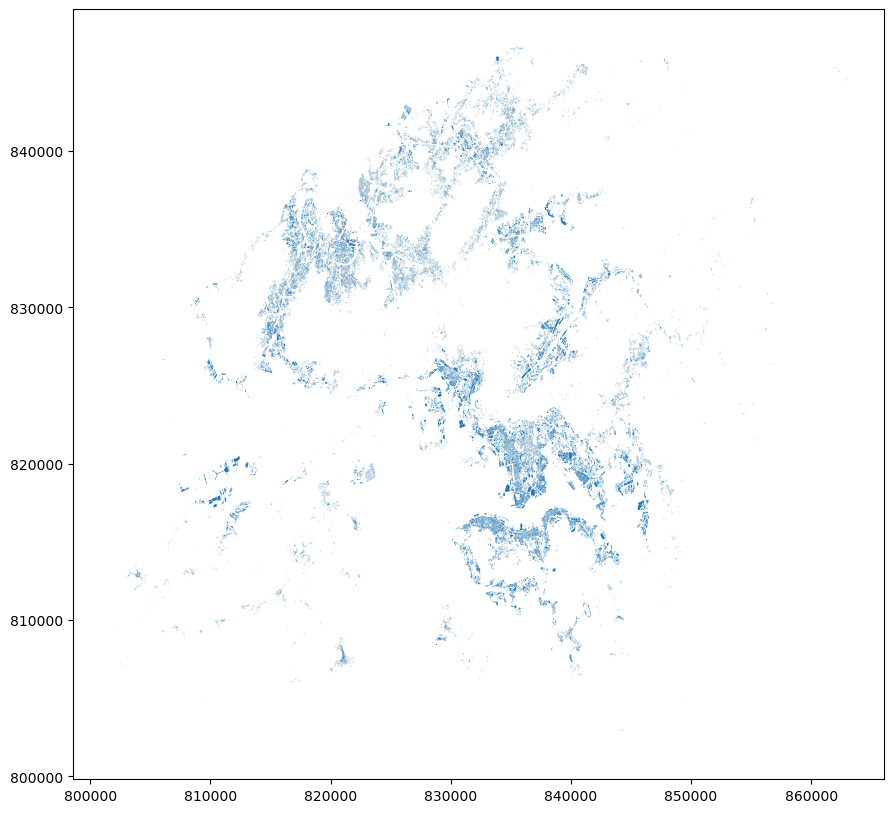

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
bd_dic['BUILDING_STRUCTURE'].plot(ax=ax)